# 날씨데이터와 업종별 배달 주문건수 탐색적자료분석(EDA)

### AWS Jupyter Notebook에서 Maria DB 날씨 데이터 불러오기

In [7]:
import pymysql
import pandas as pd

conn = pymysql.connect(host='multi-bigdata.cljkqcsbb9ok.ap-northeast-2.rds.amazonaws.com',
                       port=3306,
                       user='edu03',
                       passwd='edu03',
                       db='edudb01',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    cur = conn.cursor()
    sql = '''
        SELECT * 
        FROM ASOS_Weather_D
        '''
    cur.execute(sql)
    result = cur.fetchall()
finally:
    conn.close()
print('마리아에서 불러온 행 수 :', len(result))

dfweather_D = pd.DataFrame(result)
dfweather_D.rename({'date':'dt', 'city':'sido'}, axis=1, inplace=True)
dfweather_D['dt'] = pd.to_datetime(dfweather_D['dt']) # object --> datetime 형식으로 변경
display(dfweather_D)

마리아에서 불러온 행 수 : 22920


,sido,dt,temp_avg,temp_min,temp_max,amount_of_rain,wind_vel_max,wind_vel_avg,dewpoint_avg,r_humidity,vapor_pressure_avg,station_pressure_avg,sealevel_pressure_avg,daylight_hour
0,강원도,2017-01-01,1.9,-6.2,12.1,0.0,9.5,1.5,-3.4,70.8,4.8,1000.7,1027.4,5.1
1,강원도,2017-01-02,4.2,-3.4,14.2,0.0,13.0,2.0,-1.0,71.2,5.7,995.0,1021.2,4.2
2,강원도,2017-01-03,2.3,-6.2,12.3,0.0,9.6,1.8,-6.3,58.1,3.9,996.1,1022.5,7.4
3,강원도,2017-01-04,2.7,-6.6,10.8,0.0,9.8,1.4,-4.4,62.9,4.5,997.2,1023.7,7.7
4,강원도,2017-01-05,1.6,-8.4,9.3,4.4,5.8,1.5,-2.1,78.5,5.4,1002.8,1029.5,0.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22915,충청북도,2020-10-27,10.6,1.4,20.3,0.0,5.5,0.8,5.8,75.4,9.3,1001.2,1021.8,8.2
22916,충청북도,2020-10-28,11.9,2.2,20.0,0.0,7.5,1.5,4.2,63.4,8.6,1002.2,1022.7,6.4
22917,충청북도,2020-10-29,7.9,-1.9,17.0,0.0,4.8,1.1,-1.3,57.6,5.6,1003.5,1024.4,8.9
22918,충청북도,2020-10-30,8.6,-1.3,18.7,0.0,4.9,0.8,1.7,65.7,6.9,1005.3,1026.1,9.4


### 다중공선성문제 (독립변수들간에 선형성을 가지는 경우 발생)

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

Multicollinearity_checkdf = dfweather_D.loc[:,'temp_avg':]

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Multicollinearity_checkdf.values, i) for i in range(Multicollinearity_checkdf.shape[1])]
vif["features"] = Multicollinearity_checkdf.columns
vif

,VIF Factor,features
0,1382.251681,temp_avg
1,77.724568,temp_min
2,364.438679,temp_max
3,1.550353,amount_of_rain
4,19.005343,wind_vel_max
5,18.883839,wind_vel_avg
6,606.109148,dewpoint_avg
7,1070.572323,r_humidity
8,38.983857,vapor_pressure_avg
9,46756.058851,station_pressure_avg


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 10 이상인 features 제거 (5이상: 유의, 10이상 제거, 제거순서는 높은것부터, 비슷한 수치중에서는 둘 중 하나만 제거 <-- 작업 반복)
Multicollinearity_checkdf.drop(['temp_min','temp_max','wind_vel_max','dewpoint_avg', 'daylight_hour',
                                'vapor_pressure_avg', 'station_pressure_avg', 'sealevel_pressure_avg'], axis=1, inplace=True)

# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(Multicollinearity_checkdf.values, i) for i in range(Multicollinearity_checkdf.shape[1])]
vif["features"] = Multicollinearity_checkdf.columns
vif

# 기온 변수들간 독립성이 확보된 '평균기온', '강수량', '평균풍속', '상대습도'를 활용

,VIF Factor,features
0,4.080190,temp_avg
1,1.148450,amount_of_rain
2,3.595677,wind_vel_avg
3,7.263581,r_humidity


In [10]:
import numpy as np

dfweather_D.set_index('sido', inplace=True)
dfweather_D.drop(['temp_min','temp_max','wind_vel_max','dewpoint_avg', 'daylight_hour',
                  'vapor_pressure_avg', 'station_pressure_avg', 'sealevel_pressure_avg'], axis=1, inplace=True)
display(dfweather_D)

,dt,temp_avg,amount_of_rain,wind_vel_avg,r_humidity
sido,,,,,
강원도,2017-01-01,1.9,0.0,1.5,70.8
강원도,2017-01-02,4.2,0.0,2.0,71.2
강원도,2017-01-03,2.3,0.0,1.8,58.1
강원도,2017-01-04,2.7,0.0,1.4,62.9
강원도,2017-01-05,1.6,4.4,1.5,78.5
...,...,...,...,...,...
충청북도,2020-10-27,10.6,0.0,0.8,75.4
충청북도,2020-10-28,11.9,0.0,1.5,63.4
충청북도,2020-10-29,7.9,0.0,1.1,57.6


### 배달 주문데이터가 있는 2019-07-18 ~ 2020-08-31 중 주문데이터가 충분한 서울데이터만 가져옴
### 코로나 이전/이후로 나누어 날씨데이터를 가져옴 (2020-05-18 하루 배달데이터 존재X)

In [12]:
weather_seoul = dfweather_D.filter(like='서울특별시', axis=0) # 지역별로 데이터프레임을 리스트에 담음
weather_seoul = weather_seoul.loc[(weather_seoul.dt >= '2019-07-18') & (weather_seoul.dt <= '2020-08-31'), :]
weather_seoul = weather_seoul[weather_seoul['dt'] != '2020-05-18'] # 조건행 삭제

weather_seoul = weather_seoul.groupby(['dt']).sum()
weather_seoul

,temp_avg,amount_of_rain,wind_vel_avg,r_humidity
dt,,,,
2019-07-18,26.9,0.0,1.2,65.0
2019-07-19,28.6,0.0,1.5,61.3
2019-07-20,28.0,1.1,2.1,66.9
2019-07-21,25.1,6.2,2.2,87.1
2019-07-22,26.7,0.1,2.2,74.6
...,...,...,...,...
2020-08-27,27.1,8.7,3.6,84.6
2020-08-28,27.3,13.6,1.6,89.1
2020-08-29,26.8,13.6,1.3,90.1


In [15]:
weather_seoul[weather_seoul['amount_of_rain']>0]['amount_of_rain'].describe()

count    141.000000
mean      13.975887
std       21.480446
min        0.100000
25%        1.000000
50%        3.600000
75%       16.600000
max      103.100000
Name: amount_of_rain, dtype: float64

In [33]:
import numpy as np


def binning(df, col, rain):
    if rain > df[df[col]>0][col].describe()['75%']:
        return 'rain4'
    elif rain > df[df[col]>0][col].describe()['50%']:
        return 'rain3'
    elif rain > df[df[col]>0][col].describe()['25%']:
        return 'rain2'
    elif rain >= df[df[col]>0][col].describe()['min']:
        return 'rain1'
    else:
        return 'rain0'

weather_seoul = dfweather_D.filter(like='서울특별시', axis=0) # 지역별로 데이터프레임을 리스트에 담음

weather_seoul_bc = weather_seoul.loc[(weather_seoul.dt >= '2019-07-18') & (weather_seoul.dt <= '2020-02-29'), :]
weather_seoul_ac = weather_seoul.loc[(weather_seoul.dt > '2020-02-29') & (weather_seoul.dt <= '2020-08-31'), :]
weather_seoul_ac = weather_seoul_ac[weather_seoul_ac['dt'] != '2020-05-18'] # 조건행 삭제

weather_seoul_bc = weather_seoul_bc.groupby(['dt']).sum()
weather_seoul_ac = weather_seoul_ac.groupby(['dt']).sum()

# 강수량 분포가 0인 날이 훨씬 많아 정규분포가 아니기 때문에 강수량 유무열도 추가해보기(레이블 인코딩) 
weather_seoul_bc["rain_bin"] = weather_seoul_bc["amount_of_rain"].apply(lambda x: binning(weather_seoul_bc, 'amount_of_rain', x))
weather_seoul_ac["rain_bin"] = weather_seoul_ac["amount_of_rain"].apply(lambda x: binning(weather_seoul_ac, 'amount_of_rain', x))
# weather_region.drop('amount_of_rain', axis=1, inplace=True)

display(weather_seoul_bc.head(3))
display(weather_seoul_ac.head(3))

,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain_bin
dt,,,,,
2019-07-18,26.9,0.0,1.2,65.0,rain0
2019-07-19,28.6,0.0,1.5,61.3,rain0
2019-07-20,28.0,1.1,2.1,66.9,rain2


,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain_bin
dt,,,,,
2020-03-01,5.8,0.2,2.0,71.8,rain1
2020-03-02,3.4,0.0,2.7,55.3,rain0
2020-03-03,4.8,0.0,2.6,57.0,rain0


In [46]:
onehot_weather_bc = pd.get_dummies(weather_seoul_bc['rain_bin'])
onehot_weather_bc = pd.concat([weather_seoul_bc, onehot_weather_bc], axis=1)
onehot_weather_bc.drop('rain_bin', axis=1, inplace=True)
display(onehot_weather_bc.head(3))

onehot_weather_ac = pd.get_dummies(weather_seoul_ac['rain_bin'])
onehot_weather_ac = pd.concat([weather_seoul_ac, onehot_weather_ac], axis=1)
onehot_weather_ac.drop('rain_bin', axis=1, inplace=True)
display(onehot_weather_ac.head(3))

,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,
2019-07-18,26.9,0.0,1.2,65.0,1,0,0,0,0
2019-07-19,28.6,0.0,1.5,61.3,1,0,0,0,0
2019-07-20,28.0,1.1,2.1,66.9,0,0,1,0,0


,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,
2020-03-01,5.8,0.2,2.0,71.8,0,1,0,0,0
2020-03-02,3.4,0.0,2.7,55.3,1,0,0,0,0
2020-03-03,4.8,0.0,2.6,57.0,1,0,0,0,0


### AWS Jupyter Notebook에서 Maria DB 배달주문 데이터 불러오기

In [47]:
import pymysql
import pandas as pd

conn = pymysql.connect(host='multi-bigdata.cljkqcsbb9ok.ap-northeast-2.rds.amazonaws.com',
                       port=3306,
                       user='edu03',
                       passwd='edu03',
                       db='edudb01',
                       cursorclass=pymysql.cursors.DictCursor)
try:
    cur = conn.cursor()
    sql = '''
        SELECT * 
        FROM DeliveryOrder
        '''
    cur.execute(sql)
    result = cur.fetchall()
finally:
    conn.close()
print('마리아에서 불러온 행 수 :', len(result))

deliverydf_D = pd.DataFrame(result)
deliverydf_D.rename({'sigu':'sido'}, axis=1, inplace=True)
deliverydf_D['sido'].replace('제주특별자치도', '제주도', inplace=True)
deliverydf_D['dt'] = pd.to_datetime(deliverydf_D['dt'])
display(deliverydf_D)

마리아에서 불러온 행 수 : 191306


,dt,product,sido,sigungu,ordercnt,orderamt
0,2019-07-18,도시락,경기도,고양시 일산동구,35,35909
1,2019-07-18,도시락,경기도,고양시 일산서구,19,29513
2,2019-07-18,도시락,경기도,광명시,3,75430
3,2019-07-18,도시락,경기도,부천시,2,26000
4,2019-07-18,도시락,경기도,의정부시,53,20669
...,...,...,...,...,...,...
191301,2020-08-31,회,전라남도,나주시,2,35500
191302,2020-08-31,회,전라북도,군산시,53,36211
191303,2020-08-31,회,제주도,서귀포시,5,32800
191304,2020-08-31,회,충청남도,서산시,2,42000


In [48]:
import pandas as pd

deliverydf_D.info()
print(deliverydf_D.isnull().sum()) # 열별로 null값 확인 (None은 모두 세종특별자치시이고 세종특별자치시로 채워넣는다)

deliverydf_D.loc[(deliverydf_D['sido']=='세종특별자치시'),:]
deliverydf_D.fillna('세종특별자치시', inplace=True)

print(deliverydf_D['sido'].unique()) # 17개 대도시

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191306 entries, 0 to 191305
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   dt        191306 non-null  datetime64[ns]
 1   product   191306 non-null  object        
 2   sido      191306 non-null  object        
 3   sigungu   190929 non-null  object        
 4   ordercnt  191306 non-null  int64         
 5   orderamt  191306 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 8.8+ MB
dt            0
product       0
sido          0
sigungu     377
ordercnt      0
orderamt      0
dtype: int64
['경기도' '경상남도' '서울특별시' '강원도' '제주도' '충청북도' '대구광역시' '전라남도' '전라북도' '대전광역시'
 '광주광역시' '부산광역시' '인천광역시' '충청남도' '경상북도' '울산광역시' '세종특별자치시']


### 업종(상품)건수 합계와 평균주문금액 합계의 비중을 탐색적자료분석(EDA)

### 날씨 변수가 배달주문과 영향이 있는지 업종(16개 메뉴)별 상관분석

In [49]:
delivery_pdf = pd.pivot_table(deliverydf_D,                 # 피벗할 데이터프레임
                              index=['dt','sido'],          # 행 위치에 들어갈 열
                              columns='product',            # 열 위치에 들어갈 열
                              values='ordercnt',            # 데이터로 사용할 열
                              aggfunc='mean')               # 데이터 집계 함수 (도시별 평균 주문건수)

# 해당일 해당시군구에서 배달데이터가 없는 업종(상품) 결측치는 0으로 처리
delivery_pdf.fillna(0, inplace=True)

delivery_pdf = delivery_pdf.astype('int') # 주문건수 정수화
display(delivery_pdf) # 6620행

product           도시락  돈까스/일식  배달전문업체   분식  심부름  아시안/양식   야식  족발/보쌈  중식  찜탕  \
dt         sido                                                               
2019-07-18 강원도      0       9       0   60    0       6    0      2  12   1   
           경기도     22      84      29  111   27      48   57     90  13  37   
           경상남도    13       0       0   16    0      12    3      0   0  10   
           광주광역시    0       0       0    0    0       0    0      0   0   0   
           대구광역시    0       0       0  145    0       0    0      0   0   0   
...               ...     ...     ...  ...  ...     ...  ...    ...  ..  ..   
2020-08-31 전라남도     0      14      40   42    0       0    0     24   3  16   
           전라북도    32       7     100  233    9       1  203     96  27  94   
           제주도      0      21       0   71   37       3   73      7  27  39   
           충청남도     7      46     129   86    0      18   22     48  34   5   
           충청북도     8      63       0   12    0      12    7      2  16   2   

product            치킨  카페/디저트  패스트푸드  피자   한식   회  
dt         sido                                    
2019-07-18 강원도     41      23      0   0    0   0  
           경기도    201      28     82  55  129  35  
           경상남도    19       4     45   0   30   0  
           광주광역시    0       3      0   0    0   0  
           대구광역시    0       0      0   0   62   0  
...               ...     ...    ...  ..  ...  ..  
2020-08-31 전라남도    84      45     54  11  118   2  
           전라북도   220      53     18   7  239  53  
           제주도    127      13      3  95  163   5  
           충청남도    43      30    162  98   89   2  
           충청북도    75      40     15   0   50   8  

[6620 rows x 16 columns]

In [50]:
delivery_seoul = delivery_pdf.xs('서울특별시', level='sido')
delivery_seoul_bc = delivery_seoul.loc['2019-07-18':'2020-02-29']
delivery_seoul_ac = delivery_seoul.loc['2020-03-01':'2020-08-31']
    
display(delivery_seoul_bc)

product,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회
dt,,,,,,,,,,,,,,,,
2019-07-18,7,6,0,112,0,55,11,31,24,4,132,22,129,35,57,9
2019-07-19,8,15,8,119,0,62,14,43,21,6,227,31,150,35,63,11
2019-07-20,5,18,7,139,0,92,14,72,37,11,237,46,172,43,69,14
2019-07-21,2,15,14,135,0,84,37,51,41,6,218,49,214,48,67,13
2019-07-22,5,25,7,96,0,45,28,31,22,4,255,35,101,35,60,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-25,14,22,2,117,0,28,29,69,33,15,161,36,102,86,54,19
2020-02-26,10,19,10,96,0,23,26,78,51,20,169,38,83,103,48,15
2020-02-27,14,22,0,103,0,27,32,64,46,22,195,40,88,104,53,19


In [57]:
import pandas as pd

delivery_alltime = pd.concat([delivery_seoul_bc, delivery_seoul_ac], axis=0) # 위아래 행방향 결합
display(delivery_alltime)

product,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회
dt,,,,,,,,,,,,,,,,
2019-07-18,7,6,0,112,0,55,11,31,24,4,132,22,129,35,57,9
2019-07-19,8,15,8,119,0,62,14,43,21,6,227,31,150,35,63,11
2019-07-20,5,18,7,139,0,92,14,72,37,11,237,46,172,43,69,14
2019-07-21,2,15,14,135,0,84,37,51,41,6,218,49,214,48,67,13
2019-07-22,5,25,7,96,0,45,28,31,22,4,255,35,101,35,60,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-27,25,41,97,91,0,29,35,93,42,12,205,35,124,47,66,16
2020-08-28,19,38,85,96,0,36,57,102,52,13,264,65,149,52,80,29
2020-08-29,11,48,100,97,0,37,64,143,60,19,313,85,162,86,98,33


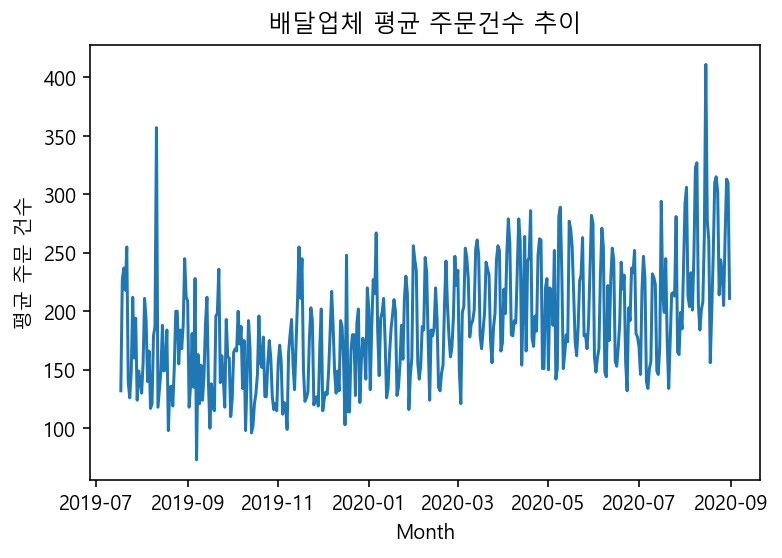

In [76]:
import matplotlib.pyplot as plt

### 폰트 오류 해결 ###
from matplotlib import font_manager, rc
font_path = "../data/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
#####################

%config InlineBackend.figure_format='retina' # 화면 해상도 향상

plt.plot(delivery_alltime.index, delivery_alltime['치킨'])
plt.title("배달업체 평균 주문건수 추이")
plt.ylabel('평균 주문 건수')
plt.xlabel('Month')

# plt.savefig('./deliverytrend.png')
plt.show()

In [52]:
import pandas as pd

pd.set_option('display.max_columns', 100) #생략없이 출력 가능

delivery_weather_bc = pd.merge(delivery_seoul_bc, onehot_weather_bc, how='left', left_index=True, right_index=True)
delivery_weather_ac = pd.merge(delivery_seoul_ac, onehot_weather_ac, how='left', left_index=True, right_index=True)

display(delivery_weather_bc.head(3)) # 서울
display(delivery_weather_ac.head(3)) # 서울
print(delivery_weather_bc.isnull().sum()) # 결측치 없음 확인

,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-18,7,6,0,112,0,55,11,31,24,4,132,22,129,35,57,9,26.9,0.0,1.2,65.0,1,0,0,0,0
2019-07-19,8,15,8,119,0,62,14,43,21,6,227,31,150,35,63,11,28.6,0.0,1.5,61.3,1,0,0,0,0
2019-07-20,5,18,7,139,0,92,14,72,37,11,237,46,172,43,69,14,28.0,1.1,2.1,66.9,0,0,1,0,0


,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0,30,5,139,0,34,63,120,65,32,235,73,122,147,55,23,5.8,0.2,2.0,71.8,0,1,0,0,0
2020-03-02,12,26,2,100,0,27,31,52,45,15,149,45,81,75,47,17,3.4,0.0,2.7,55.3,1,0,0,0,0
2020-03-03,7,22,2,99,0,25,30,80,23,16,121,38,93,90,54,15,4.8,0.0,2.6,57.0,1,0,0,0,0


도시락               0
돈까스/일식            0
배달전문업체            0
분식                0
심부름               0
아시안/양식            0
야식                0
족발/보쌈             0
중식                0
찜탕                0
치킨                0
카페/디저트            0
패스트푸드             0
피자                0
한식                0
회                 0
temp_avg          0
amount_of_rain    0
wind_vel_avg      0
r_humidity        0
rain0             0
rain1             0
rain2             0
rain3             0
rain4             0
dtype: int64


### 정규화 (변수들간에 단위가 불일치하는 문제를 해결하고자 정규화 시켜줌)

In [53]:
import pandas as pd
from sklearn import preprocessing

x = delivery_weather_bc.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
delivery_weather_nbc = pd.DataFrame(x_scaled, index=delivery_weather_bc.index, columns=delivery_weather_bc.columns)

x = delivery_weather_ac.values # returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
delivery_weather_nac = pd.DataFrame(x_scaled, index=delivery_weather_ac.index, columns=delivery_weather_ac.columns)

display(delivery_weather_nbc.head(3)) # 서울
display(delivery_weather_nac.head(3))

,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-18,0.233333,0.000000,0.000000,0.390244,0.0,0.426966,0.000000,0.062500,0.243902,0.000000,0.207746,0.057895,0.525140,0.107527,0.299065,0.12500,0.882206,0.000000,0.111111,0.531685,1.0,0.0,0.0,0.0,0.0
2019-07-19,0.266667,0.191489,0.222222,0.432927,0.0,0.505618,0.061224,0.169643,0.207317,0.048780,0.542254,0.105263,0.642458,0.107527,0.355140,0.18750,0.924812,0.000000,0.166667,0.474498,1.0,0.0,0.0,0.0,0.0
2019-07-20,0.166667,0.255319,0.194444,0.554878,0.0,0.842697,0.061224,0.428571,0.402439,0.170732,0.577465,0.184211,0.765363,0.150538,0.411215,0.28125,0.909774,0.017405,0.277778,0.561051,0.0,0.0,1.0,0.0,0.0


,도시락,돈까스/일식,배달전문업체,분식,심부름,아시안/양식,야식,족발/보쌈,중식,찜탕,치킨,카페/디저트,패스트푸드,피자,한식,회,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
dt,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.000000,0.340426,0.020492,0.635659,0.0,0.588235,0.803922,0.778761,0.565789,0.933333,0.393103,0.540230,0.537879,1.000000,0.278689,0.555556,0.152778,0.00194,0.200000,0.687500,0.0,1.0,0.0,0.0,0.0
2020-03-02,0.428571,0.255319,0.008197,0.333333,0.0,0.382353,0.176471,0.176991,0.302632,0.366667,0.096552,0.218391,0.227273,0.357143,0.147541,0.333333,0.069444,0.00000,0.400000,0.477041,1.0,0.0,0.0,0.0,0.0
2020-03-03,0.250000,0.170213,0.008197,0.325581,0.0,0.323529,0.156863,0.424779,0.013158,0.400000,0.000000,0.137931,0.318182,0.491071,0.262295,0.259259,0.118056,0.00000,0.371429,0.498724,1.0,0.0,0.0,0.0,0.0


In [56]:
# 지역별 주문 업종과 기온간의 상관관계 확인

delivery_bc_cor = delivery_weather_nbc.corr()
delivery_bc_cor = delivery_bc_cor.loc['도시락':'회', 'temp_avg':]
display(delivery_bc_cor) # 코로나 이전 상관계수

delivery_ac_cor = delivery_weather_nac.corr()
delivery_ac_cor = delivery_ac_cor.loc['도시락':'회', 'temp_avg':]
display(delivery_ac_cor) # 코로나 이후 상관계수

# 서울에서는 돈까스/일식, 배달전문업체가 평균기온에 따라 주문건수가 상관관계를 가짐

,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
도시락,-0.179746,0.036187,0.071503,-0.012878,-0.062389,-0.103016,0.103692,0.116375,-0.000833
돈까스/일식,0.406169,0.124285,-0.136332,0.257399,-0.116851,0.012685,-0.001618,0.125934,0.061454
배달전문업체,0.363159,0.024867,-0.024475,0.171752,-0.048495,-0.010782,0.011707,0.036045,0.046747
분식,0.044635,0.107001,-0.017824,0.158027,-0.216636,0.090657,0.016261,0.103579,0.155278
심부름,0.121797,-0.030711,0.027057,0.047406,0.043627,-0.011556,-0.072469,0.025210,-0.018586
아시안/양식,0.483171,0.195939,-0.080376,0.363072,-0.200640,0.032526,0.046879,0.104976,0.158343
야식,-0.109094,-0.031354,0.117403,0.059166,-0.059920,-0.008914,0.047053,0.048232,0.018480
족발/보쌈,-0.158569,-0.023904,0.018914,-0.015007,-0.026656,-0.051029,-0.069160,0.187590,-0.023045
중식,0.111643,0.073332,-0.097693,0.183996,-0.125453,0.079341,-0.028211,0.089376,0.068207
찜탕,0.060866,-0.026812,0.044329,0.051179,-0.011960,0.025476,-0.117210,0.075720,0.029409


,temp_avg,amount_of_rain,wind_vel_avg,r_humidity,rain0,rain1,rain2,rain3,rain4
도시락,0.328818,0.080839,-0.054061,0.179045,-0.116403,-0.007028,0.097208,0.100695,0.006536
돈까스/일식,0.688847,0.228793,-0.289048,0.607083,-0.320500,0.067269,0.089871,0.122817,0.261189
배달전문업체,0.589368,0.127684,-0.113788,0.429648,-0.201820,0.061642,0.032066,0.126011,0.120510
분식,-0.453742,-0.044179,0.098131,-0.245299,-0.010034,0.020713,-0.010825,0.040854,-0.034316
심부름,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
아시안/양식,-0.298629,-0.033555,0.037016,-0.152553,0.013953,-0.073268,-0.048370,0.109597,-0.009571
야식,-0.181986,0.106408,0.028100,0.032134,-0.185281,0.042994,0.049017,0.102117,0.118596
족발/보쌈,-0.198786,-0.032539,0.002050,-0.100041,-0.055327,-0.029580,0.027984,0.110720,-0.014567
중식,0.108344,0.262253,-0.027282,0.251254,-0.194992,-0.019161,-0.047767,0.024786,0.373038
찜탕,-0.660189,-0.116881,0.236235,-0.390368,0.117540,-0.066619,-0.129015,0.106238,-0.107903


## 서울 이외의 다른 지역에서는 주문데이터가 충분하지 않았기에 다른지역은 제외함

## 결론 : 서울에서는 기온이 높아지는 여름철에 (돈까스/일식), (배달주문업체), (아시안/양식)이 양의 상관관계를 가졌고, (피자)와 (회)는 음의 상관관계를 보이며 배달주문이 감소함을 발견하였음

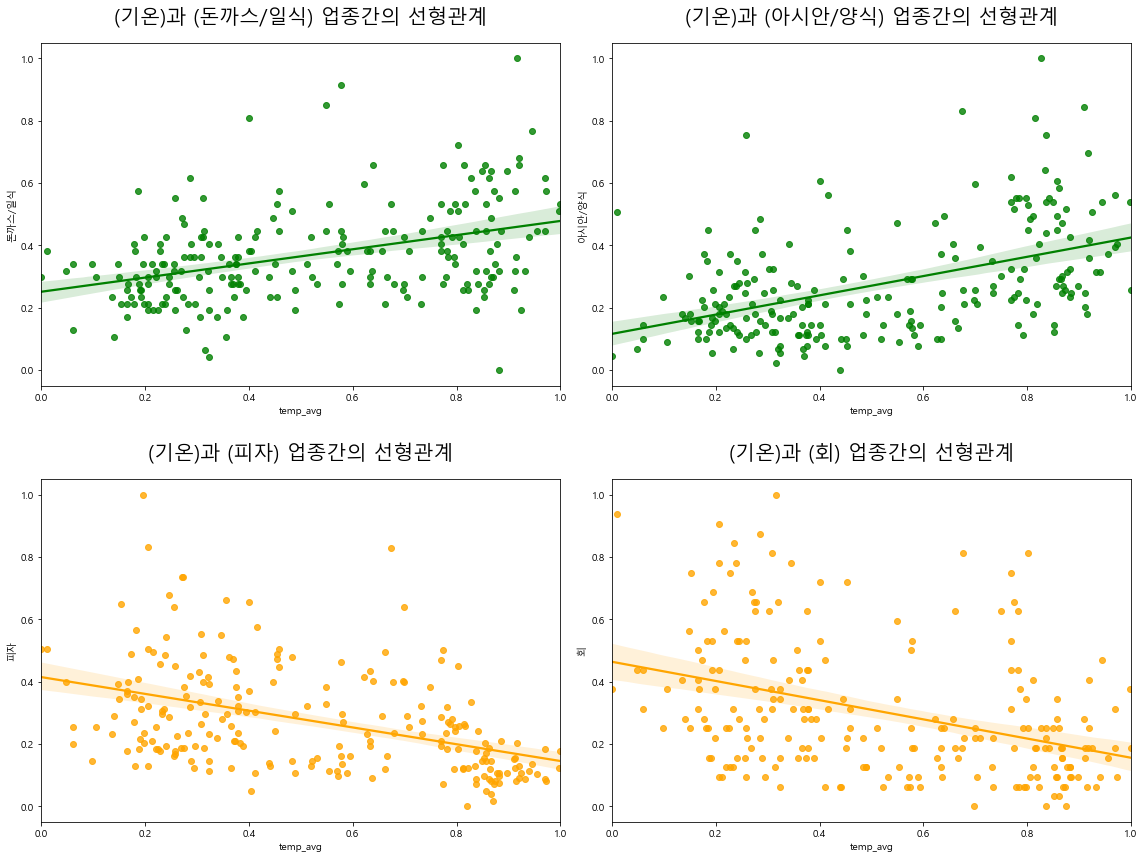

In [445]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 폰트 오류 해결 ###
from matplotlib import font_manager, rc
font_path = "../data/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)
#####################

# 그래프 객체 생성 (figure에 3개의 서브 플롯을 생성)
fig = plt.figure(figsize=(16,12))   
ax1 = fig.add_subplot(2,2, 1)
ax1.text(x=0.5, y=1.1, s='(기온)과 (돈까스/일식) 업종간의 선형관계', fontsize=20, weight='bold', ha='center', va='bottom')

ax2 = fig.add_subplot(2,2, 2)
ax2.text(x=0.5, y=1.1, s='(기온)과 (아시안/양식) 업종간의 선형관계', fontsize=20, weight='bold', ha='center', va='bottom')

ax3 = fig.add_subplot(2,2, 3)
ax3.text(x=0.5, y=1.1, s='(기온)과 (피자) 업종간의 선형관계', fontsize=20, weight='bold', ha='center', va='bottom')

ax4 = fig.add_subplot(2,2, 4)
ax4.text(x=0.5, y=1.1, s='(기온)과 (회) 업종간의 선형관계', fontsize=20, weight='bold', ha='center', va='bottom')

# 그래프 그리기 - 선형회귀선 표시(fit_reg=True)
sns.regplot(x='temp_avg',                   # x축 변수
            y='돈까스/일식',                 # y축 변수
            data=delivery_weather_ndf[8],   # 데이터
            color='g',                      # marker color
            ax=ax1)                         # ax 객체 - 1번째 그래프

sns.regplot(x='temp_avg',                   # x축 변수
            y='아시안/양식',                 # y축 변수
            data=delivery_weather_ndf[8],   # 데이터
            color='g',                      # marker color
            ax=ax2)                         # ax 객체 - 2번째 그래프

sns.regplot(x='temp_avg',                   # x축 변수
            y='피자',                       # y축 변수
            data=delivery_weather_ndf[8],   # 데이터
            color='orange',                      # marker color
            ax=ax3)                         # ax 객체 - 3번째 그래프

sns.regplot(x='temp_avg',                   # x축 변수
            y='회',                         # y축 변수
            data=delivery_weather_ndf[8],   # 데이터
            color='orange',                      # marker color
            ax=ax4)                         # ax 객체 - 4번째 그래프


# delivery_weather_ndf[8].plot(kind='scatter', x='temp_avg', y='돈까스/일식')
# plt.plot(delivery_weather_ndf[8].index, delivery_weather_ndf[8]['temp_avg'])
# plt.plot(delivery_weather_ndf[8].index, delivery_weather_ndf[8]['배달전문업체'])

plt.tight_layout(h_pad=3) # 위아래 padding
plt.show()

## 다중회귀분석

In [156]:
from sklearn import linear_model

menu_list = ['도시락', '돈까스/일식', '배달전문업체', '분식', '심부름', '아시안/양식', '야식',
            '족발/보쌈', '중식', '찜탕', '치킨', '카페/디저트', '패스트푸드', '피자', '한식', '회']
for menu in menu_list:
    regdf = delivery_weather_df[[menu, 'temp_avg', 'wind_vel_avg', 'daylight_hour', 'rain_bin']]
    indepv = ['temp_avg', 'wind_vel_avg', 'daylight_hour', 'rain_bin']
    X=regdf[indepv]
    y=regdf[menu]

    linear_regression = linear_model.LinearRegression()
    linear_regression.fit(X = pd.DataFrame(X), y = y)
    prediction = linear_regression.predict(X = pd.DataFrame(X))
    # print('a value = ', linear_regression.intercept_)
    # print('b balue = ', linear_regression.coef_)

    residuals = y-prediction
    # residuals.describe()

    SSE = (residuals**2).sum()
    SST = ((y-y.mean())**2).sum()
    R_squared = 1 - (SSE/SST)
    print(menu, 'R_squared = ', R_squared)

도시락 R_squared =  0.03282614181415133
돈까스/일식 R_squared =  0.3329676196830239
배달전문업체 R_squared =  0.25639649406149534
분식 R_squared =  0.06296040027442473
심부름 R_squared =  0.00817468473189964
아시안/양식 R_squared =  0.05718323348393417
야식 R_squared =  0.03276459610867588
족발/보쌈 R_squared =  0.016171120740820277
중식 R_squared =  0.07638776276934356
찜탕 R_squared =  0.05712063429965608
치킨 R_squared =  0.05897463180216045
카페/디저트 R_squared =  0.03797195551435206
패스트푸드 R_squared =  0.05880551943298451
피자 R_squared =  0.09755036385761895
한식 R_squared =  0.12347053098058891
회 R_squared =  0.036606519209567034


In [84]:
residuals = y-prediction
residuals.describe()

count    410.000000
mean       0.000000
std        0.214206
min       -0.354302
25%       -0.158341
50%       -0.064608
75%        0.140515
max        0.620543
Name: 회, dtype: float64

In [147]:
SSE = (residuals**2).sum()
SST = ((y-y.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  0.17891437234210594


In [148]:
from sklearn.metrics import mean_squared_error
print('score = ', linear_regression.score(X = pd.DataFrame(X), y=y))
print('Mean_Squared_Error = ', mean_squared_error(prediction, y))
print('RMSE = ', mean_squared_error(prediction, y)**0.5)

score =  0.17891437234210594
Mean_Squared_Error =  124042.61585804366
RMSE =  352.1968424873279
